# Constant-Q Transform Spectral Envelope Coefficients (CQT-SEC)

## Test the cqtsec module

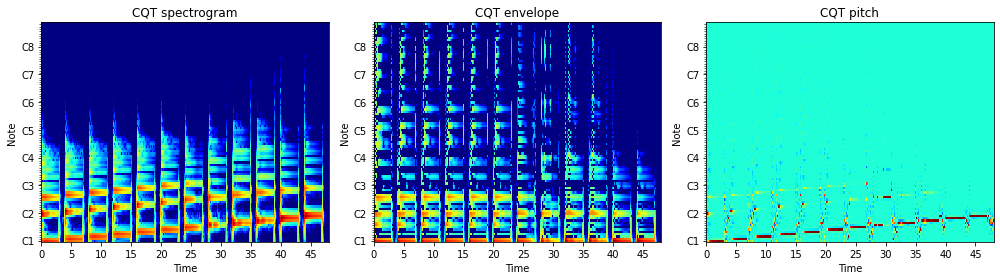

In [3]:
import os
import numpy as np
import librosa
import librosa.display
import cqtsec
import matplotlib.pyplot as plt

# Define the parameters
folder_path = r'C:\Users\zarafii2001\Gracenote\Data\nsynth\nsynth-train\audio'
instrument_names = ['bass_acoustic_000']
note_number = 24
note_numbers = np.arange(note_number, note_number+12)
velocity_number = 75
sampling_frequency = 16000

# Initialize the audio signal
audio_signal = np.empty(0)

# Loop over the instrument names and note numbers
for instrument_name in instrument_names:
    for note_number in note_numbers:
    
        # Get the path to the file
        file_name = f'{instrument_name}-{note_number:03d}-{velocity_number:03d}.wav'
        file_path = os.path.join(folder_path, file_name)
        
        # Load the current audio signal and concatenate them
        audio_signal1, _ = librosa.load(file_path, sr=sampling_frequency, mono=True)
        audio_signal = np.concatenate((audio_signal, audio_signal1))


# Define the parameters
window_length = pow(2, int(np.ceil(np.log2(0.04 * sampling_frequency))))
step_length = int(window_length / 2)
minimum_frequency = 32.70
octave_resolution = 12
number_coefficients = 20

# Compute the CQT spectrogram, envelope, and pitch, the CQT-SECs, and the MFCCs
cqt_spectrogram = np.power(cqtsec.cqt(audio_signal, sampling_frequency, step_length, minimum_frequency, octave_resolution), 2)
cqt_envelope, cqt_pitch = cqtsec.cqtdeconv(cqt_spectrogram)
cqt_sec = cqtsec.cqtsec(audio_signal, sampling_frequency, step_length, minimum_frequency, octave_resolution, \
                        number_coefficients)
audio_mfcc = cqtsec.mfcc(audio_signal, sampling_frequency, window_length, step_length, number_coefficients)

# # Display everything
# plt.figure(figsize=(14, 7))
# plt.subplot(2, 3, 1)
# librosa.display.specshow(librosa.power_to_db(cqt_spectrogram), x_axis='time', y_axis='cqt_note', sr=sampling_frequency, 
#                          hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, cmap='jet')
# plt.title('CQT spectrogram')
# plt.subplot(2, 3, 2)
# librosa.display.specshow(librosa.power_to_db(cqt_envelope), x_axis='time', y_axis='cqt_note', sr=sampling_frequency, 
#                          hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, cmap='jet')
# plt.title('CQT envelope')
# plt.subplot(2, 3, 3)
# librosa.display.specshow(cqt_pitch, x_axis='time', y_axis='cqt_note', sr=sampling_frequency, 
#                          hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, cmap='jet')
# plt.title('CQT pitch')
# plt.subplot(2, 3, 5)
# librosa.display.specshow(cqt_sec, x_axis='time', cmap='jet')
# plt.title('CQT-SECs')
# plt.subplot(2, 3, 6)
# librosa.display.specshow(audio_mfcc, x_axis='time', cmap='jet')
# plt.title('MFCCs')
# plt.tight_layout()
# plt.show()

# Display everything
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(librosa.power_to_db(cqt_spectrogram), x_axis='time', y_axis='cqt_note', sr=sampling_frequency, 
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, cmap='jet')
plt.title('CQT spectrogram')
plt.subplot(1, 3, 2)
librosa.display.specshow(librosa.power_to_db(cqt_envelope), x_axis='time', y_axis='cqt_note', sr=sampling_frequency, 
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, cmap='jet')
plt.title('CQT envelope')
plt.subplot(1, 3, 3)
librosa.display.specshow(cqt_pitch, x_axis='time', y_axis='cqt_note', sr=sampling_frequency, 
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, cmap='jet')
plt.title('CQT pitch')
plt.tight_layout()
plt.show()

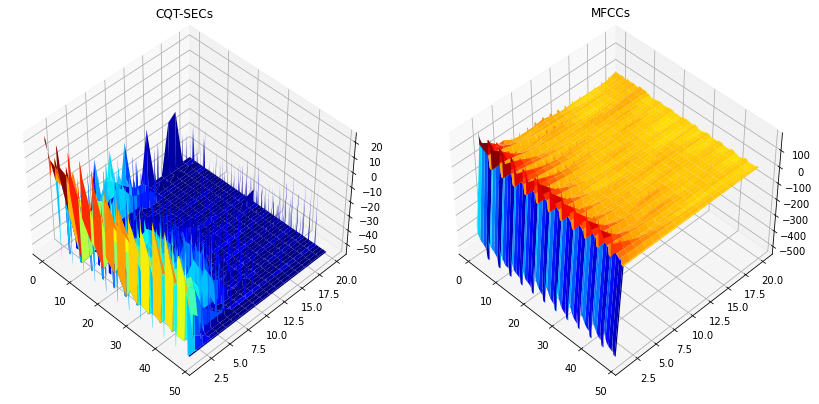

In [137]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

number_coefficients, number_times = np.shape(cqt_sec)
X = np.linspace(0, 48, number_times)
Y = np.linspace(1, number_coefficients, number_coefficients)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X, Y, librosa.power_to_db(cqt_sec), cmap='jet')
ax.view_init(45, -45)
ax.set_title('CQT-SECs')

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, audio_mfcc, cmap='jet')
ax.view_init(45, -45)
ax.set_title('MFCCs')

plt.show()

## 01. Assumption and observations

### 01.1. Assumption

A log-spectrum, such as the CQT-spectrum, can be represented as the convolution of a pitch-independent spectral envelope component (~ timbre) and a energy-normalized pitch component.

`X = E * P`

### 01.2. Observation 1

A pitch change in the audio translates to a linear shift in the log-spectrum. 

This means that the same musical object at different pitches should have a similar envelope component but a shifted pitch component; while two different musical objects at the same pitch should have different envelope components but a similar pitch component.

- `X = E * P`

- `X2 = E2 * P2`

`=> E ~ E2`

#### Example 1: Two sinusoids at different pitches and their CQT-spectrogram

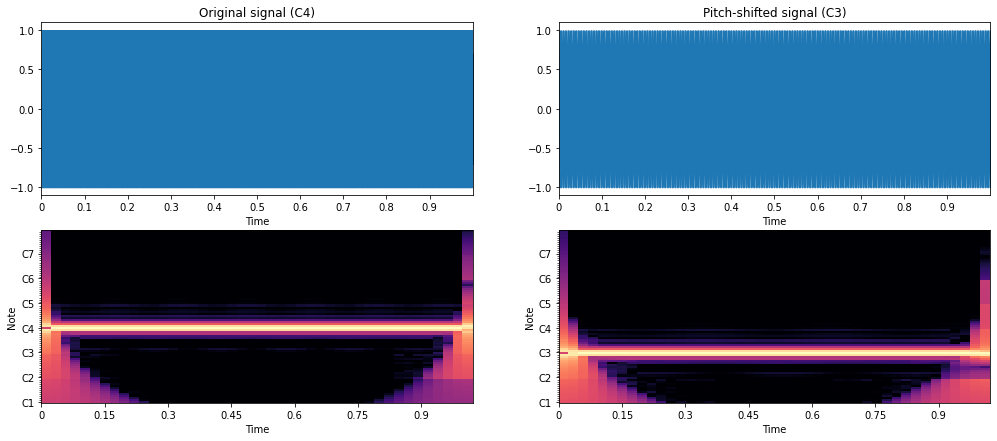

In [10]:
%matplotlib inline

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define two sinusoids, with one twice lower in frequency than the other one
sampling_frequency = 44100                                     # In Hz
time_duration = 1                                              # In seconds
time_array = np.arange(0, time_duration, 1/sampling_frequency) # In seconds
frequency_value1 = 261.63                                      # In Hz (= C4)
frequency_value2 = frequency_value1/2                          # In Hz (= C3)
audio_signal1 = np.sin(time_array*2*np.pi*frequency_value1)
audio_signal2 = np.sin(time_array*2*np.pi*frequency_value2)

# Comptute the CQT spectrogram for the signals
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
audio_spectrogram1 = np.abs(librosa.cqt(audio_signal1, sr=sampling_frequency, hop_length=step_length))
audio_spectrogram2 = np.abs(librosa.cqt(audio_signal2, sr=sampling_frequency, hop_length=step_length))

# Display their waveform in seconds and their power CQT spectrogram in seconds and notes
plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
librosa.display.waveplot(audio_signal1, sr=sampling_frequency)
plt.title('Original signal (C4)')
plt.subplot(2, 2, 2)
librosa.display.waveplot(audio_signal2, sr=sampling_frequency)
plt.title('Pitch-shifted signal (C3)')
plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(audio_spectrogram1, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note')
plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(audio_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note')
plt.show()

#### Example 2: Two notes at different pitches and their CQT-spectrogram

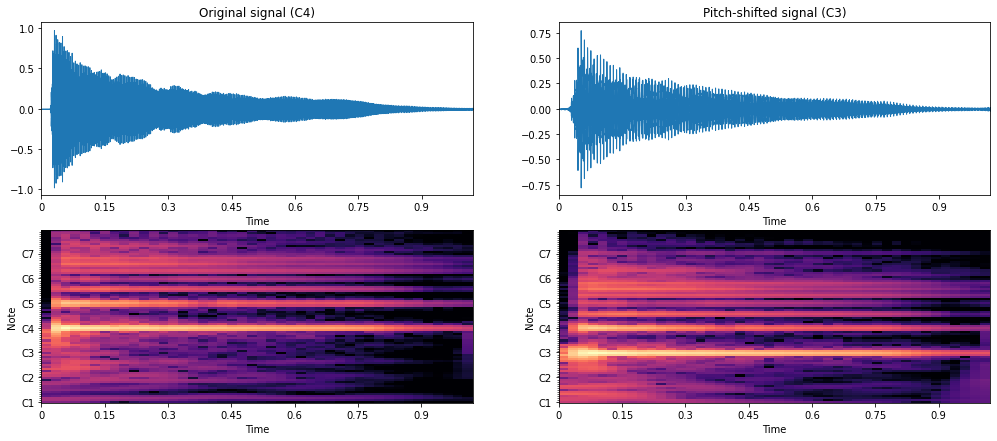

In [9]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file with its sampling frequency, and keep only one note in its left channel (= C4)
file_path = r'94812__digifishmusic__c4-major-scale-piano.wav'
audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=False)
audio_signal1 = audio_signal[0, 24000:69000]

# Shift down the note by a whole octave (2x lower in frequency) (= C3)
audio_signal2 = librosa.effects.pitch_shift(audio_signal1, sampling_frequency, n_steps=-12)

# Comptute the CQT spectrogram for the signals
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
audio_spectrogram1 = np.abs(librosa.cqt(audio_signal1, sr=sampling_frequency, hop_length=step_length))
audio_spectrogram2 = np.abs(librosa.cqt(audio_signal2, sr=sampling_frequency, hop_length=step_length))

# Display their waveform in seconds and their power CQT spectrogram in seconds and notes
plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
librosa.display.waveplot(audio_signal1, sr=sampling_frequency)
plt.title('Original signal (C4)')
plt.subplot(2, 2, 2)
librosa.display.waveplot(audio_signal2, sr=sampling_frequency)
plt.title('Pitch-shifted signal (C3)')
plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(audio_spectrogram1, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note')
plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(audio_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note')
plt.show()

### 01.3. Observation 2

The Fourier transform (FT) of a convolution of two functions is equal to the point-wise product of their FTs (convolution theorem).

- `F(X) = F(E) . F(P)`
- `F(X2) = F(E2) . F(P2)`

`=> F(E) ~ F(E2)`

#### Example: Direct vs indirect convolution

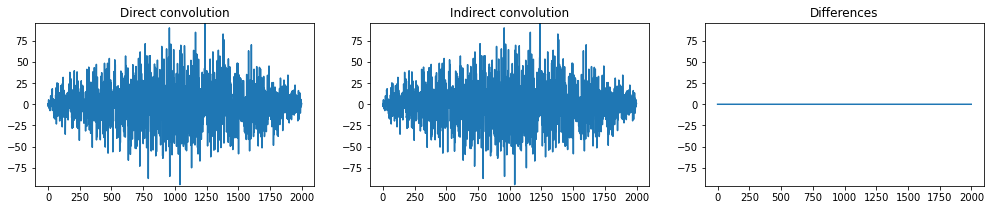

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define two arrays
number_elements = 1000
data_array1 = np.random.normal(size=number_elements)
data_array2 = np.random.normal(size=number_elements)

# Compute the direct convolution between them
data_convolution = np.convolve(data_array1, data_array2)

# Compute the convolution using the convolution theorem
ft_array1 = np.fft.fft(data_array1, 2*number_elements-1)
ft_array2 = np.fft.fft(data_array2, 2*number_elements-1)
data_convolution2 = np.real(np.fft.ifft(ft_array1*ft_array2))

# Display the convolutions and their differences
maximum_value = max(abs(data_convolution))
plt.figure(figsize=(17, 3))
plt.subplot(1, 3, 1)
plt.plot(data_convolution), plt.ylim(-maximum_value, maximum_value), plt.title('Direct convolution')
plt.subplot(1, 3, 2)
plt.plot(data_convolution2), plt.ylim(-maximum_value, maximum_value), plt.title('Indirect convolution')
plt.subplot(1, 3, 3)
plt.plot(data_convolution-data_convolution2), plt.ylim(-maximum_value, maximum_value), plt.title('Differences')
plt.show()

### 01.4. Observation 3

The magnitude FT is shift-invariant.

- `F(X) = abs(F(X)) . exp(j*angle(F(X)))`

- `F(X2) = abs(F(X2)) . exp(j*angle(F(X2)))`

`=> abs(F(X)) ~ abs(F(X2))`

Conclusion:

`=> F(E) ~ abs(F(X)) => E ~ F-1(abs(F(X))) and P ~ F-1(exp(j*angle(F(X))))`

#### Example 1: An array and a shifted version of it, and their magnitude FT

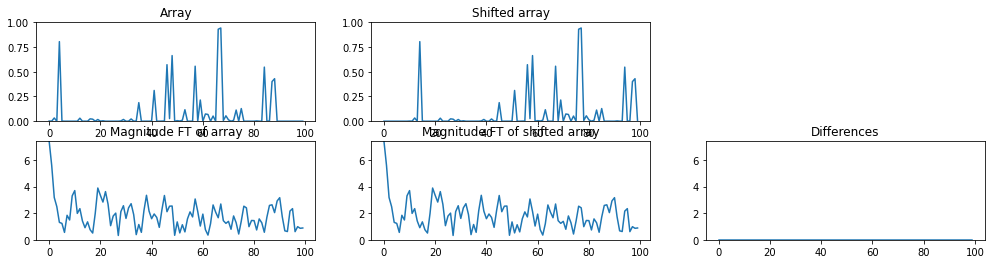

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define a non-negative array and a shifted version of it
number_elements = 100
delay_size = 10
data_array1 = np.concatenate((np.power(np.random.rand(number_elements-delay_size), 10), np.zeros(delay_size)))
data_array2 = np.concatenate((np.zeros(delay_size), data_array1[0:number_elements-delay_size]))

# Compute the magnitude FT of the arrays
absft_array1 = abs(np.fft.fft(data_array1, 2*number_elements-1))[0:number_elements]
absft_array2 = abs(np.fft.fft(data_array2, 2*number_elements-1))[0:number_elements]

# Display the arrays and magnitude FTs
maximum_value = max(np.max(absft_array1), np.max(absft_array2))
plt.figure(figsize=(17, 4))
plt.subplot(2, 3, 1), plt.plot(data_array1), plt.ylim(0, 1), plt.title('Array')
plt.subplot(2, 3, 2), plt.plot(data_array2), plt.ylim(0, 1), plt.title('Shifted array')
plt.subplot(2, 3, 4), plt.plot(absft_array1), plt.ylim(0, maximum_value), plt.title('Magnitude FT of array')
plt.subplot(2, 3, 5), plt.plot(absft_array2), plt.ylim(0, maximum_value), plt.title('Magnitude FT of shifted array')
plt.subplot(2, 3, 6), plt.plot(abs(absft_array1-absft_array2)), plt.ylim(0, maximum_value), plt.title('Differences')
plt.show()

#### Example 2: A CQT spectrum and a pitch-shifted version of it, and their magnitude FT

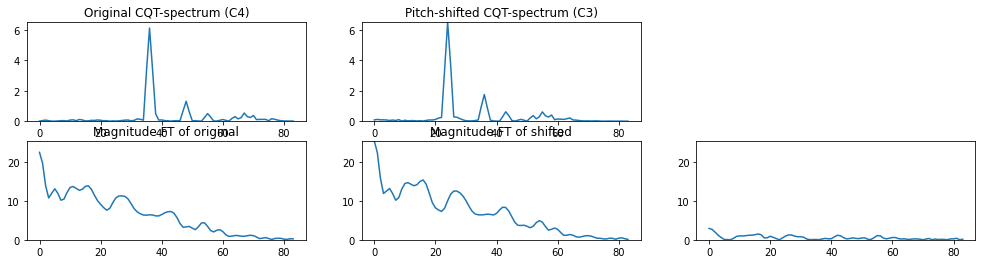

In [31]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Load an audio file with its sampling frequency, and keep only one note in its left channel (= C4)
file_path = r'94812__digifishmusic__c4-major-scale-piano.wav'
audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=False)
audio_signal1 = audio_signal[0, 24000:69000]

# Shift down the note by a whole octave (2x lower in frequency) (= C3)
audio_signal2 = librosa.effects.pitch_shift(audio_signal1, sampling_frequency, n_steps=-12)

# Comptute the CQT-spectrogram for the signals
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
audio_spectrogram1 = np.abs(librosa.cqt(audio_signal1, sr=sampling_frequency, hop_length=step_length))
audio_spectrogram2 = np.abs(librosa.cqt(audio_signal2, sr=sampling_frequency, hop_length=step_length))
number_frequencies = np.shape(audio_spectrogram1)[0]

# Compute the magnitude FT of the CQT-spectrograms
absft_spectrogram1 = abs(np.fft.fft(audio_spectrogram1, 2*number_frequencies-1, axis=0))[0:number_frequencies, :]
absft_spectrogram2 = abs(np.fft.fft(audio_spectrogram2, 2*number_frequencies-1, axis=0))[0:number_frequencies, :]

# Display their waveform in seconds and their power CQT-spectrogram in seconds and notes
i = 10
audio_maximum = max(np.max(abs(audio_spectrogram1[:, i])), np.max(abs(audio_spectrogram2[:, i])))
absft_maximum = max(np.max(abs(absft_spectrogram1[:, i])), np.max(abs(absft_spectrogram2[:, i])))
plt.figure(figsize=(17, 4))
plt.subplot(2, 3, 1), plt.plot(audio_spectrogram1[:, i]), plt.ylim(0, audio_maximum), plt.title('Original CQT-spectrum (C4)')
plt.subplot(2, 3, 2), plt.plot(audio_spectrogram2[:, i]), plt.ylim(0, audio_maximum), plt.title('Pitch-shifted CQT-spectrum (C3)')
plt.subplot(2, 3, 4), plt.plot(absft_spectrogram1[:, i]), plt.ylim(0, absft_maximum), plt.title('Magnitude FT of original')
plt.subplot(2, 3, 5), plt.plot(absft_spectrogram2[:, i]), plt.ylim(0, absft_maximum), plt.title('Magnitude FT of shifted')
plt.subplot(2, 3, 6), plt.plot(abs(absft_spectrogram1[:, i]-absft_spectrogram2[:, i])), plt.ylim(0, absft_maximum)
plt.show()

## 02. Preliminary Tests

### 02.1. Compare librosa's and zaf's CQT-spectrogram and MFCC

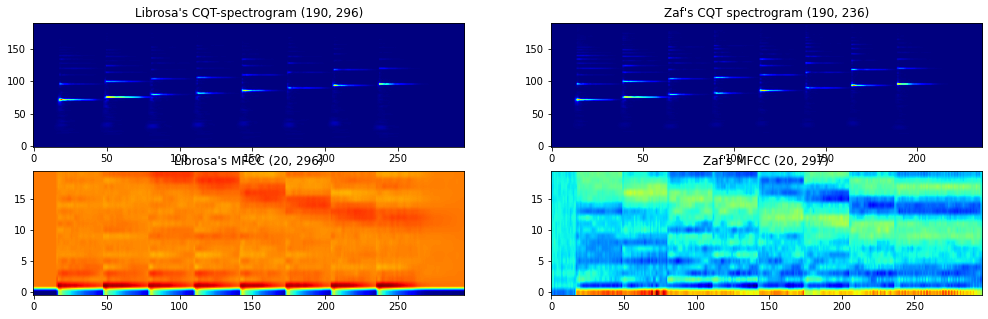

In [33]:
import numpy as np
import librosa
import zaf
import scipy.signal
import matplotlib.pyplot as plt

# Load an audio file in mono
file_path = r'94812__digifishmusic__c4-major-scale-piano.wav'
sampling_frequency = 16000
audio_signal, sampling_frequency = librosa.load(file_path, sr=sampling_frequency, mono=True)

# Define some parameters
window_length = pow(2, int(np.ceil(np.log2(0.04 * sampling_frequency))))
step_length = int(window_length/2)
window_function = scipy.signal.hamming(window_length, sym=False)
minimum_frequency = 32.70
maximum_frequency = sampling_frequency/2
octave_resolution = 24
time_resolution = 25
number_mels = 40
number_coefficients = 20

# Compute the CQT-spectrogram using librosa and zaf
number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                     fmin=minimum_frequency, n_bins=number_frequencies, bins_per_octave=octave_resolution))
cqt_kernel = zaf.cqtkernel(sampling_frequency, octave_resolution, minimum_frequency, maximum_frequency)
cqt_spectrogram2 = zaf.cqtspectrogram(audio_signal, sampling_frequency, time_resolution, cqt_kernel)

# Compute the MFCCs using librosa and zaf
audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_mfcc=number_coefficients, \
                                  hop_length=step_length)
mel_filterbank = zaf.melfilterbank(sampling_frequency, window_length, number_mels)
audio_mfcc2 = zaf.mfcc(audio_signal, window_function, step_length, mel_filterbank, number_coefficients)

# Display the CQT-spectrograms and the MFCCs
plt.figure(figsize=(17, 5))
plt.subplot(2, 2, 1)
plt.imshow(cqt_spectrogram, aspect='auto', cmap='jet', origin='lower')
plt.title(f"Librosa's CQT-spectrogram {np.shape(cqt_spectrogram)}")
plt.subplot(2, 2, 2)
plt.imshow(cqt_spectrogram2, aspect='auto', cmap='jet', origin='lower')
plt.title(f"Zaf's CQT spectrogram {np.shape(cqt_spectrogram2)}")
plt.subplot(2, 2, 3)
plt.imshow(audio_mfcc, aspect='auto', cmap='jet', origin='lower')
plt.title(f"Librosa's MFCC {np.shape(audio_mfcc)}")
plt.subplot(2, 2, 4)
plt.imshow(audio_mfcc2, aspect='auto', cmap='jet', origin='lower')
plt.title(f"Zaf's MFCC {np.shape(audio_mfcc2)}")
plt.show()

### 02.2. Test decomposing the CQT-spectrogram into a CQT-envelope and a CQT-pitch

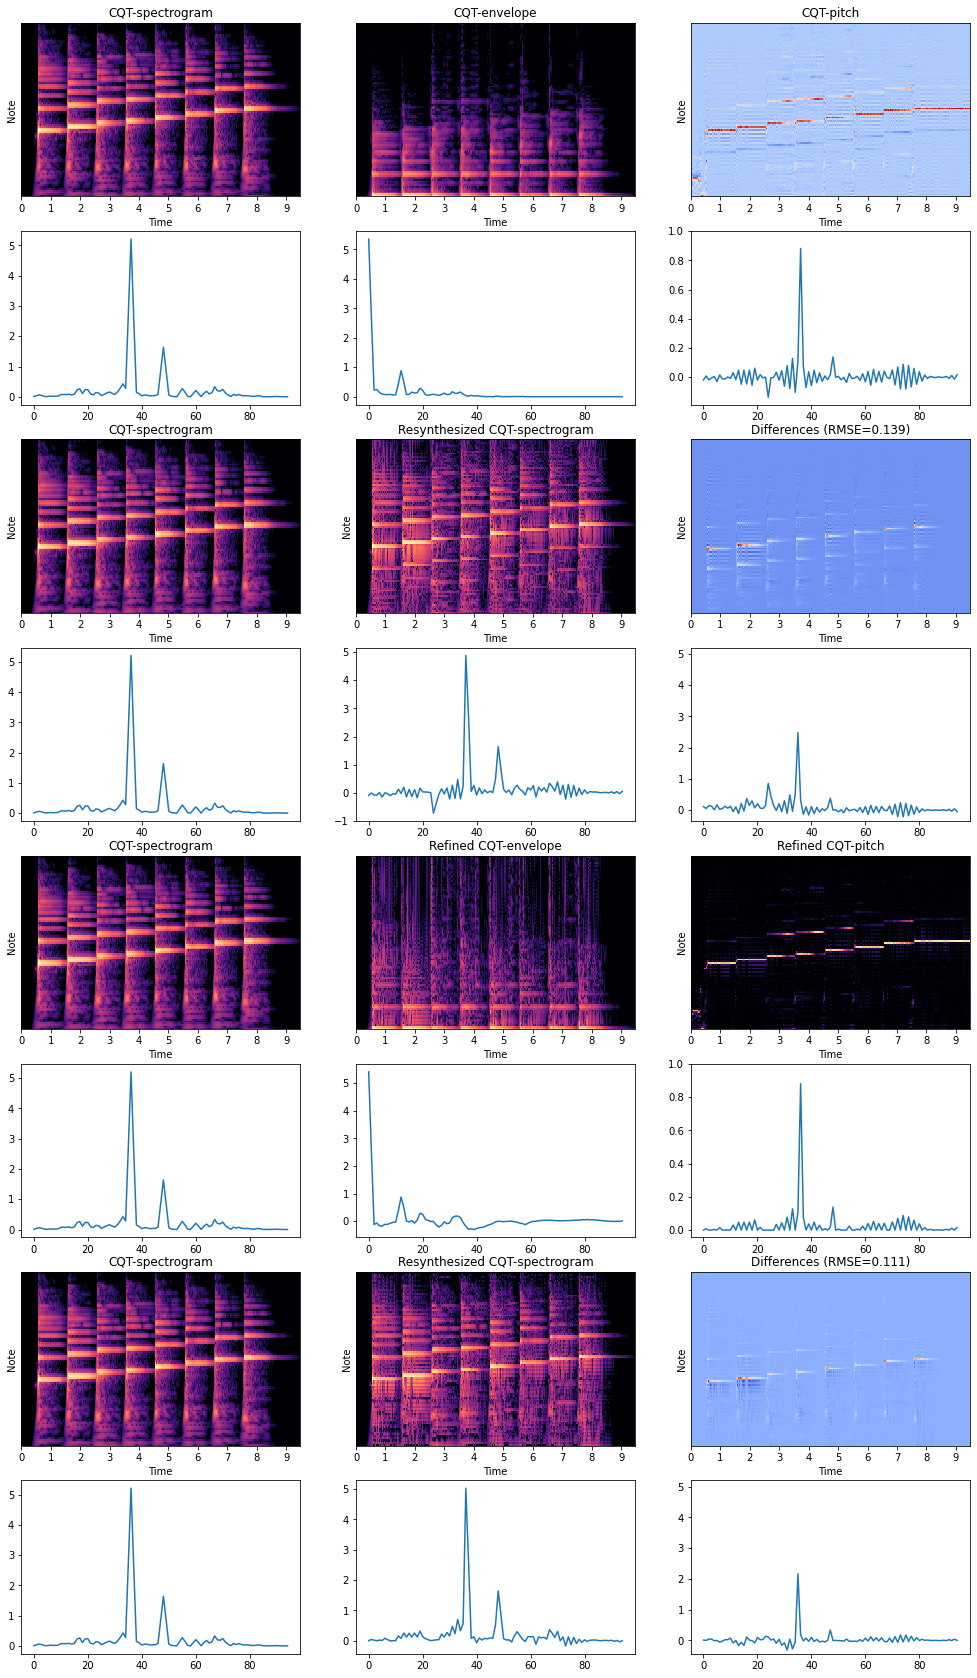

In [34]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings('ignore',category=matplotlib.cbook.mplDeprecation)

# Load an audio file with its sampling frequency, and keep only its left channel
file_path = r'94812__digifishmusic__c4-major-scale-piano.wav'
# file_path = r'557469__oleviolin__d-scale-violin.wav'
sampling_frequency = 16000
audio_signal, _ = librosa.load(file_path, sr=sampling_frequency, mono=True)

# Comptute the CQT-spectrogram of the signal
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
minimum_frequency = 32.70
maximum_frequency = sampling_frequency/2
octave_resolution = 12
number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
audio_cqt = librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                        n_bins=number_frequencies, bins_per_octave=octave_resolution)
cqt_spectrogram = np.abs(audio_cqt)
number_times = np.shape(cqt_spectrogram)[1]

# Derive the CQT-envelope and the CQT-pitch
ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
absftcqt_spectrogram = abs(ftcqt_spectrogram)
cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/absftcqt_spectrogram, axis=0)[0:number_frequencies, :])

# Resynthesize the spectrogram by convolving the CQT-envelope and CQT-pitch
cqt_spectrogram2 = np.zeros((number_frequencies, number_times))
for i in range(number_times):
    cqt_spectrogram2[:, i] = np.convolve(cqt_envelope[:, i], cqt_pitch[:, i])[0:number_frequencies]

# Display the CQT-spectrogram, CQT-envelope and CQT-pitch, the resynthesized CQT-spectrogram, and the differences
j = 20
plt.figure(figsize=(17, 30))
plt.subplot(8, 3, 1)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT-spectrogram')
plt.subplot(8, 3, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_envelope, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time')
plt.title('CQT-envelope')
plt.subplot(8, 3, 3)
librosa.display.specshow(cqt_pitch, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                         bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
plt.title('CQT-pitch')
plt.subplot(8, 3, 4)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 5)
plt.plot(cqt_envelope[:, j])
plt.subplot(8, 3, 6)
plt.plot(cqt_pitch[:, j])
plt.ylim(top=1)
plt.subplot(8, 3, 7)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT-spectrogram')
plt.subplot(8, 3, 8)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('Resynthesized CQT-spectrogram')
plt.subplot(8, 3, 9)
librosa.display.specshow(cqt_spectrogram-cqt_spectrogram2, sr=sampling_frequency, hop_length=step_length, \
                         fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
rmse_value = np.round(np.sqrt(np.mean(np.power(cqt_spectrogram-cqt_spectrogram2, 2))), 3)
plt.title(f'Differences (RMSE={rmse_value})')
plt.subplot(8, 3, 10)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 11)
plt.plot(cqt_spectrogram2[:, j])
plt.subplot(8, 3, 12)
plt.plot(cqt_spectrogram[:, j]-cqt_spectrogram2[:, j])
plt.ylim(top=max(cqt_spectrogram[:, j]))

# Refine the CQT-pitch, and then the CQT-envelope
cqt_pitch2 = np.copy(cqt_pitch)
cqt_pitch2[cqt_pitch2 < 0] = 0
cqt_envelope2 = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch2, 2*number_frequencies-1, axis=0)+1e-7), \
                                    axis=0)[0:number_frequencies, :])

# Resynthesize the spectrogram by convolving the refined CQT-envelope and CQT-pitch
cqt_spectrogram2 = np.zeros((number_frequencies, number_times))
for i in range(number_times):
    cqt_spectrogram2[:, i] = np.convolve(cqt_envelope2[:, i], cqt_pitch2[:, i])[0:number_frequencies]

# Display the CQT-spectrogram, the refined CQT-envelope and CQT-pitch, the resynthesized CQT-spectrogram, and the differences
plt.subplot(8, 3, 13)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT-spectrogram')
plt.subplot(8, 3, 14)
librosa.display.specshow(librosa.amplitude_to_db(cqt_envelope2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time')
plt.title('Refined CQT-envelope')
plt.subplot(8, 3, 15)
librosa.display.specshow(cqt_pitch2, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                         bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
plt.title('Refined CQT-pitch')
plt.subplot(8, 3, 16)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 17)
plt.plot(cqt_envelope2[:, j])
plt.subplot(8, 3, 18)
plt.plot(cqt_pitch2[:, j])
plt.ylim(top=1)
plt.subplot(8, 3, 19)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT-spectrogram')
plt.subplot(8, 3, 20)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('Resynthesized CQT-spectrogram')
plt.subplot(8, 3, 21)
librosa.display.specshow(cqt_spectrogram-cqt_spectrogram2, sr=sampling_frequency, hop_length=step_length, \
                         fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
rmse_value = np.round(np.sqrt(np.mean(np.power(cqt_spectrogram-cqt_spectrogram2, 2))), 3)
plt.title(f'Differences (RMSE={rmse_value})')
plt.subplot(8, 3, 22)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 23)
plt.plot(cqt_spectrogram2[:, j])
plt.subplot(8, 3, 24)
plt.plot(cqt_spectrogram[:, j]-cqt_spectrogram2[:, j])
plt.ylim(top=max(cqt_spectrogram[:, j]))
plt.show()

# # Resynthesize the signal
# audio_signal2 = librosa.icqt(cqt_spectrogram2*audio_cqt/cqt_spectrogram, sr=sampling_frequency, \
#                              hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution)
# audio_signal2 = np.max(abs(audio_signal))*audio_signal2/np.max(abs(audio_signal2))
# audio_signal2 = np.pad(audio_signal2, (0, len(audio_signal)-len(audio_signal2)), 'constant', constant_values=0)

### 02.3. Test extracting the CQT-spectral envelope coefficients (CQT-SEC) directly

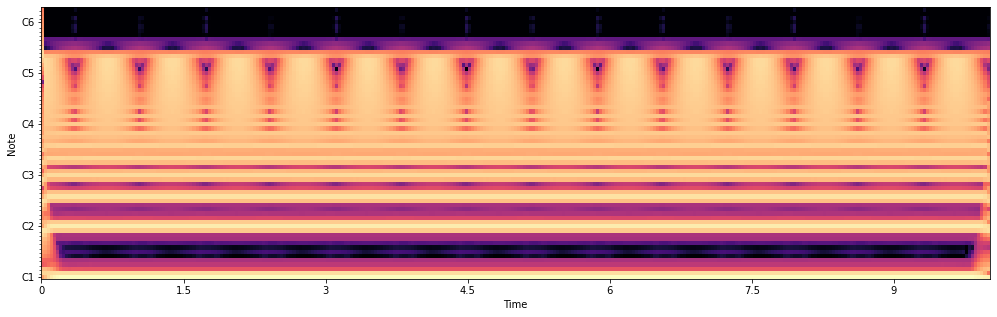

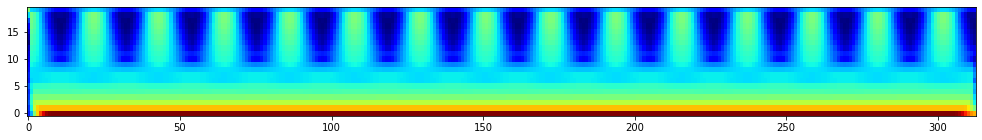

In [47]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings('ignore',category=matplotlib.cbook.mplDeprecation)

# Build a harmonic signal
sampling_frequency = 16000                                     # In Hz
time_duration = 10                                             # In seconds
time_array = np.arange(0, time_duration, 1/sampling_frequency) # In seconds
number_harmonics = 20
frequency_values = 32.70*np.arange(1, number_harmonics+1)      # in Hz
number_samples = len(time_array)
audio_signal = np.zeros(number_samples)
for frequency_value in frequency_values:
    audio_signal = audio_signal+np.sin(time_array*2*np.pi*frequency_value)

# Comptute the CQT-spectrogram of the harmonic signal
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
minimum_frequency = frequency_values[0]
maximum_frequency = 2*frequency_values[-1]
octave_resolution = 12
number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                                     n_bins=number_frequencies, bins_per_octave=octave_resolution))
plt.figure(figsize=(17, 5))
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.show()

# Extract the CQT-spectral envelope coefficients (CQT-SEC)
coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_harmonics+1))).astype(int)
cqt_sec = cqt_spectrogram[coefficient_indices, :]
plt.figure(figsize=(17, 2))
plt.imshow(cqt_sec, aspect='auto', cmap='jet', origin='lower')
plt.show()

### 02.4. Compare the CQT-SECs to the MFCCs on one audio file

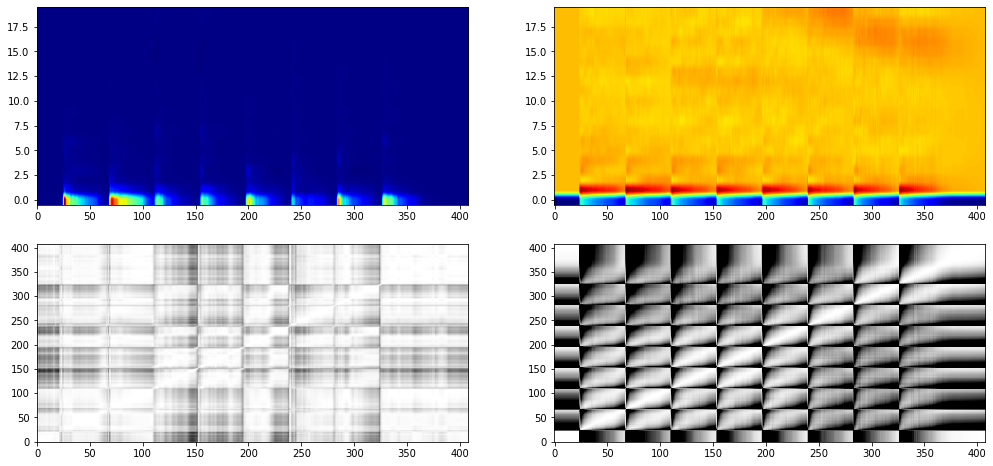

In [35]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define a function to compute the CQT spectral envelope coefficients (CQT-SEC)
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                         fmin=minimum_frequency, n_bins=number_frequencies, \
                                         bins_per_octave=octave_resolution))
    
    # Derive the CQT-envelope and the CQT-pitch
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT-envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-6), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]
    
    return cqt_sec


# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Define a function to compute a self-similarity matrix using the cosine similarity
def ssm(audio_feature):
    
    # Normalize the columns by their Euclidean norm
    audio_feature0 = audio_feature/(np.sqrt(np.sum(np.power(audio_feature, 2), axis=0))+1e-16)
    
    # Multiple the normalized columns with each other
    similarity_matrix = np.matmul(audio_feature0.T, audio_feature0)
    
    return similarity_matrix
    
    
# Load an audio file with its sampling frequency, and keep only its left channel
file_path = r'94812__digifishmusic__c4-major-scale-piano.wav'
# file_path = r'557469__oleviolin__d-scale-violin.wav'
sampling_frequency = 16000
audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
# Compute the CQT-SECs and the MFCCs
cqt_sec = cqtsec(audio_signal, sampling_frequency)
audio_mfcc = mfcc(audio_signal, sampling_frequency)

# Compute the self-similarity matrices using the cosine similarity
similarity_matrix = ssm(cqt_sec)
similarity_matrix2 = ssm(audio_mfcc)

# Display everything
plt.figure(figsize=(17, 8))
plt.subplot(2, 2, 1)
plt.imshow(cqt_sec, cmap='jet', aspect='auto', origin='lower')
plt.subplot(2, 2, 2)
plt.imshow(audio_mfcc, cmap='jet', aspect='auto', origin='lower')
plt.subplot(2, 2, 3)
plt.imshow(similarity_matrix, cmap='gray', aspect='auto', origin='lower', vmin=0.9, vmax=1)
plt.subplot(2, 2, 4)
plt.imshow(similarity_matrix2, cmap='gray', aspect='auto', origin='lower', vmin=0.9, vmax=1)
plt.show()

## 03. Test on a Small Dataset

### 03.1. Create a small dataset from the full NSynth dataset (DONE)

In [105]:
import os
from shutil import copyfile

# Create a small dataset from the large NSynth dataset
folder_path = r'C:\Users\zarafii2001\Gracenote\Data\nsynth'
folder_path2 = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
instrument_list = [{'name':'bass_acoustic', 'number': '000', 'midi': 24}, \
                   {'name':'brass_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'flute_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'guitar_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'keyboard_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'mallet_acoustic', 'number': '000', 'midi': 72}, \
                   {'name':'organ_electronic', 'number': '000', 'midi': 60}, \
                   {'name':'reed_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'string_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'synth_lead_synthetic', 'number': '000', 'midi': 60}, \
                   {'name':'vocal_acoustic', 'number': '002', 'midi': 60}]
number_semitones = 12
for i in instrument_list:
    for j in range(i['midi'], i['midi']+number_semitones):
        file_name = f'{i['name']}_{i['number']}-{j:03d}-075.wav'
        file_path = os.path.join(folder_path, file_name)
        file_path2 = os.path.join(folder_path2, file_name)
        copyfile(file_path, file_path2)

### 03.2. Compute the CQT-SECs and the MFCCs on the small dataset

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT-envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]


    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Display the name of the file
    print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)

### 03.3. Compare the note similarities for the CQT-SECs and the MFCCs

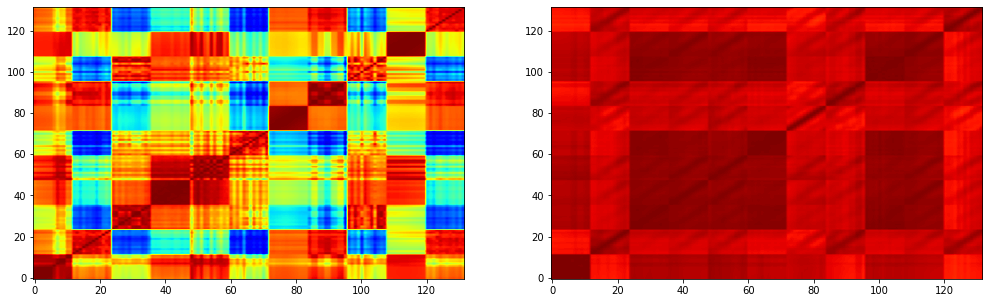

In [4]:
# Initialize the note similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_similarities = np.zeros((number_files, number_files))
mfcc_similarities = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the note similarity between the CQT-SECs and between the MFCCs
        cqtsec_similarities[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_similarities[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Display the note similarity matrices for the CQT-SECs and the MFCCs
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.imshow(cqtsec_similarities, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.subplot(1, 2, 2)
plt.imshow(mfcc_similarities, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.show()

### 03.4. Compare the instrument similarities for the CQT-SECs and the MFCCs

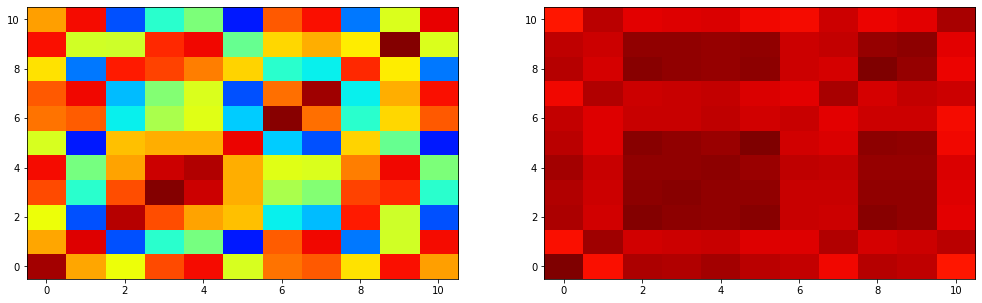

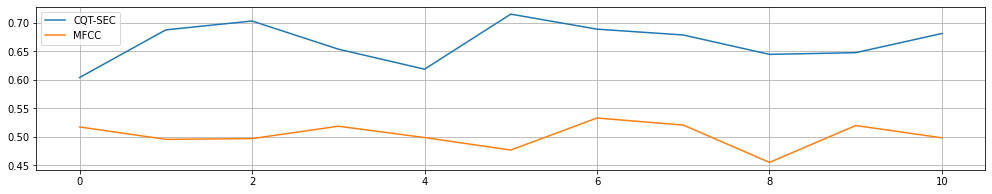

In [6]:
# Initialize the instrument similarity matrices and the final score vectors
number_instruments = 11
cqtsec_similarities2 = np.zeros((number_instruments, number_instruments))
mfcc_similarities2 = np.zeros((number_instruments, number_instruments))
cqtsec_scores2 = np.zeros(number_instruments)
mfcc_scores2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instruments
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_similarities2[i, j] = np.mean(cqtsec_similarities[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_similarities2[i, j] = np.mean(mfcc_similarities[i*12:(i+1)*12, j*12:(j+1)*12])

# Display the instrument similarity matrices
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.imshow(cqtsec_similarities2, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.subplot(1, 2, 2)
plt.imshow(mfcc_similarities2, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.show()

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_scores2[i] = (cqtsec_similarities2[i, i] \
    + 1-((np.sum(cqtsec_similarities2[i, :])-cqtsec_similarities2[i, i])/(number_instruments-1)))/2
    mfcc_scores2[i] = (cqtsec_similarities2[i, i] \
    + 1-((np.sum(mfcc_similarities2[i, :])-mfcc_similarities2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.figure(figsize=(17, 3))
plt.plot(cqtsec_scores2, label='CQT-SEC')
plt.plot(mfcc_scores2, label='MFCC')
plt.grid()
plt.legend()
plt.show()

### 03.5. Compare the instrument similarity scores for different versions of the CQT-SECs, and the MFCCs

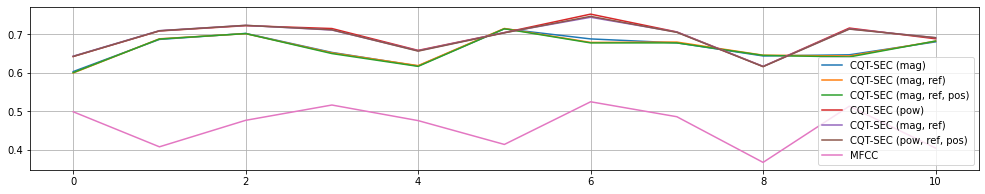

In [33]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 3))



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT-envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]
    
    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag)')



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT-envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref)')



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT-envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
    cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref, pos)')



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT-envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (pow)')



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT-envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref)')



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT-envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
    cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (pow, ref, pos)')
plt.plot(mfcc_vector2, label='MFCC')



plt.grid()
plt.legend()
plt.show()

## 04. Test on the full NSynth dataset (train, valid, and test) for medium velocity only (075) 

### 04.1. Compute the CQT-SECs and MFCCs for every file (DONE)

In [ ]:
import os
import pickle
import numpy as np
import librosa
import cqtsec

# Get the path to the dataset folder and the list of its subfolders
folder_path = r'C:\Users\zarafii2001\Gracenote\Data\nsynth'
folder_listdir = os.listdir(folder_path)

# Define the parameters
sampling_frequency = 16000
window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
step_length = int(window_length/2)
minimum_frequency = 32.70
octave_resolution = 12
number_coefficients = 20

# Set the path to the feature files
folder_path2 = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth_features'

# Loop over the subsets
i = 0
for folder_name in folder_listdir:
    
    # Get the path to the subset and the list of its files 
    subfolder_path = os.path.join(folder_path, folder_name, 'audio')
    subfolder_listdir = os.listdir(subfolder_path)
    
    # Loop over the files
    for file_name in subfolder_listdir:
        
        # Check for medium velocity only
        velocity_number = file_name.split('-')[2][0:3]
        if velocity_number == '075':
            
            # Get the path to the file
            file_path = os.path.join(subfolder_path, file_name)
            
            # Display the counter and the name of the file
            i = i+1
            print(f'{i}: {file_name}')
            
            # Load the audio signal
            audio_signal, _ = librosa.load(file_path, sr=None, mono=True)

            # Compute the CQT-SECs and the MFCCs
            cqt_sec = cqtsec.cqtsec(audio_signal, sampling_frequency, step_length, minimum_frequency, octave_resolution, \
                                    number_coefficients)
            audio_mfcc = cqtsec.mfcc(audio_signal, sampling_frequency, window_length, step_length, number_coefficients)

            # Create a dictionary for the current audio features and save it in a pkl file
            audio_dict = {'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
            file_path2 = os.path.join(folder_path2, file_name[0:-4]+'.pkl')
            pickle.dump(audio_dict, open(file_path2,'wb'))

### 04.2. Compute the instrument cross-similarities for every file using the CQT-SECs and MFCCs (DONE)

In [ ]:
import os
import pickle
import numpy as np
import librosa

# Get the path to the folder and the list of files
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth_features'
folder_listdir = os.listdir(folder_path)

# Initialize an array for the instruments indices for all the files
number_files = len(folder_listdir)
instrument_indices = np.zeros(number_files, dtype=int)

# Initialize the previous unique instrument name and the instrument index
instrument_name0 = '0'
j = -1

# Loop over the files to get the instrument indices
i = 0
for file_name in folder_listdir:
    
    # Get the name of the instrument (with the instrument number)
    instrument_name = file_name.split('-')[0]

    # Update the instrument index and previous unique name, if it is a new instrument
    if instrument_name != instrument_name0:
        j = j+1
        instrument_name0 = instrument_name

    # Update the instrument index and the file index
    instrument_indices[i] = j
    i = i+1


# Get the full feature size
audio_dict = pickle.load(open(os.path.join(folder_path, folder_listdir[0]), 'rb'))
feature_size = np.size(audio_dict['cqt-sec'])

# Initialize arrays for all the features, flatten and normalized
cqt_secs = np.zeros((feature_size, number_files))
audio_mfccs = np.zeros((feature_size, number_files))

# Loop over the files to flatten and normalize the features
i = 0
for file_name in folder_listdir:
    
#     # Print the counter and the file name
#     print(f'{i+1}/{number_files}: {file_name}')

    # Get the the full path to the file and load the dictionary
    file_path = os.path.join(folder_path, file_name)
    audio_dict = pickle.load(open(file_path, 'rb'))

    # Get the CQT-SECs, flatten them and normalize them
    cqt_sec = audio_dict['cqt-sec'].flatten()
    cqt_secs[:, i] = cqt_sec/(np.sqrt(np.sum(np.power(cqt_sec, 2)))+1e-16)

    # Get the MFCCs, flatten them and normalize them
    audio_mfcc = audio_dict['mfcc'].flatten()
    audio_mfccs[:, i] = audio_mfcc/(np.sqrt(np.sum(np.power(audio_mfcc, 2)))+1e-16)
    
    # Update the file index
    i = i+1

In [ ]:
# Get the path to the similarity folder
folder_path2 = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth_similarities'

# Get the number of instruments
number_instruments = instrument_indices[-1]+1

# Loop over the files to compute the instrument cross-similarities
i = 0
for file_name in folder_listdir:
        
    # Print the counter and the file name
    print(f'{i+1}/{number_files}: {file_name}')

    # Get the full path to the similarity file
    file_path2 = os.path.join(folder_path2, file_name)

    # If the similarity file does not already exist
    if not os.path.isfile(file_path2):

        # Compute the cosine similarity between the current features and all the others
        cqtsec_similarities = np.matmul(cqt_secs[:, i], cqt_secs[:, i+1:])
        mfcc_similarities = np.matmul(audio_mfccs[:, i], audio_mfccs[:, i+1:])

        # Initialize the instrument similarities for the current file
        cqtsec_similarities2 = np.zeros(number_instruments)
        mfcc_similarities2 = np.zeros(number_instruments)

        # Loop over the cross-similarities (past the self-similarity)
        l = 0
        for j in range(i+1, number_files):

            # Get the instrument index for the current cross-similarity
            k = instrument_indices[j]

            # Update the instrument similarities
            cqtsec_similarities2[k] = cqtsec_similarities2[k] + cqtsec_similarities[l]
            mfcc_similarities2[k] = mfcc_similarities2[k] + mfcc_similarities[l]
            l = l+1

        # Create a similarity dictionary for the current file and save it
        audio_dict = {'cqt-sec': cqtsec_similarities2, 'mfcc': mfcc_similarities2}
        pickle.dump(audio_dict, open(file_path2,'wb'))
        
    # Update the file index
    i = i+1

### 04.3. Derive the instrument similarity matrix for all the files

In [ ]:
import os
import pickle
import numpy as np

# Get the path to the folder of similarities and the list of files
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth_similarities'
folder_listdir = os.listdir(folder_path)

# Initialize an array for the instruments indices for all the files
number_files = len(folder_listdir)
instrument_indices = np.empty(number_files, dtype=int)

# Initialize the previous unique instrument name and the instrument index
instrument_name0 = '0'
j = -1

# Initialize an array for the number of notes per instrument
number_instruments = 945
note_counters = np.zeros(number_instruments, dtype=int)

# Loop over the files to get the instrument indices and note counters
for i in range(number_files):
    
    # Get the name of the instrument (with the instrument number)
    instrument_name = folder_listdir[i].split('-')[0]
    
    # If it is a new instrument
    if instrument_name != instrument_name0:
        
        # Update the instrument index and the previous unique name
        j = j+1
        instrument_name0 = instrument_name
    
    # Update the instrument index for the current file
    instrument_indices[i] = j
    
    # Update the note counter for the current instrument
    note_counters[j] = note_counters[j]+1
    
# Initialize the instrument similarity matrix for the CQT-SECs and the MFCCs
cqtsec_similarity = np.zeros((number_instruments, number_instruments))
mfcc_similarity = np.zeros((number_instruments, number_instruments))

# Loop over the files to compute the instrument similarity matrices
for i in range(number_files):
    
    # Get the file name and display it with the file counter
    file_name = folder_listdir[i]
#     print(f'{i+1}/{number_files}: {file_name}')
    
    # Get the full path to the similarity file and load the audio dictionary
    file_path = os.path.join(folder_path, file_name)
    audio_dict = pickle.load(open(file_path, 'rb'))
    
    # Get the instrument index and update the instrument similarity matrices
    j = instrument_indices[i]
    cqtsec_similarity[j, :] = cqtsec_similarity[j, :] + audio_dict['cqt-sec']
    mfcc_similarity[j, :] = mfcc_similarity[j, :] + audio_dict['mfcc']
    
# Recover the whole instrument similarity matrices
cqtsec_similarity = cqtsec_similarity+np.eye(number_instruments)+cqtsec_similarity.T
mfcc_similarity = mfcc_similarity+np.eye(number_instruments)+mfcc_similarity.T

# Derive the number of pairs of notes used for the similarities for all the pairs of instruments
note_pairs = note_counters*note_counters[:, None]

# Normalize the instrument similarity matrices
cqtsec_similarity = cqtsec_similarity/note_pairs
mfcc_similarity = mfcc_similarity/note_pairs

# Create a dictionary and save the instrument similarities
audio_dict = {'cqt-sec': cqtsec_similarity, 'mfcc': mfcc_similarity}
pickle.dump(audio_dict, open('instrument_similarity.pkl','wb'))

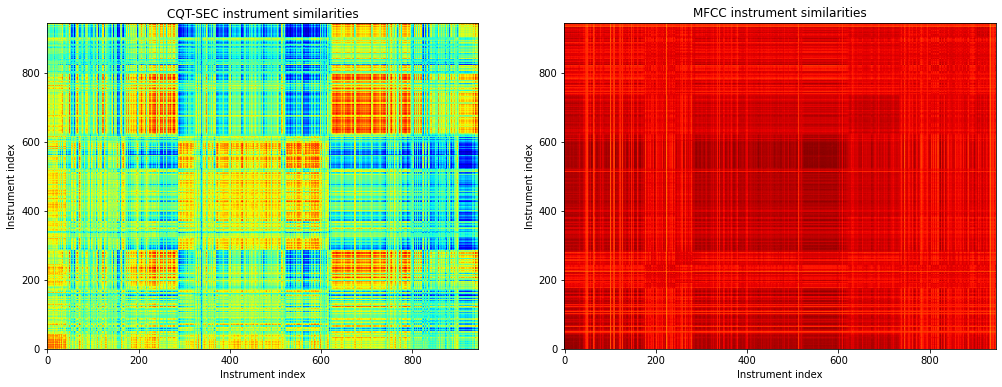

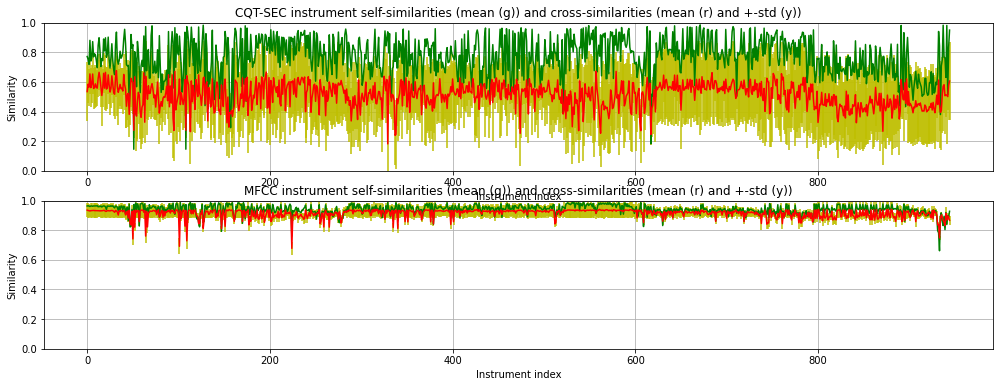

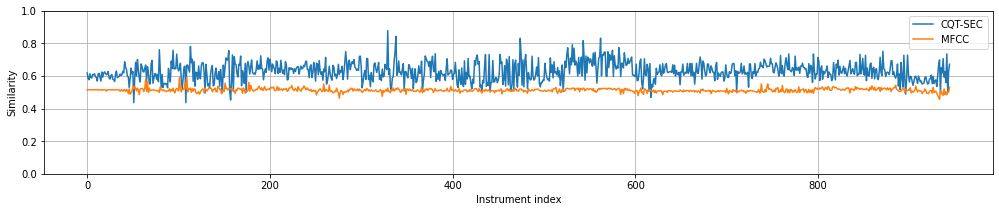

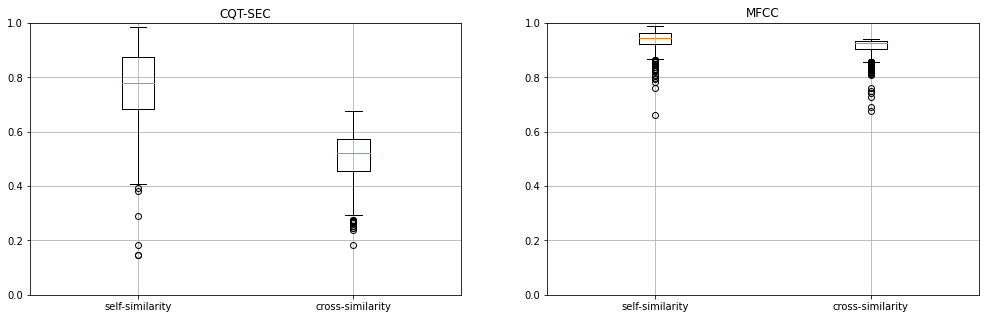

CQT-SEC score: 0.6289179470926352
MFCC score: 0.5129025186531978


In [5]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the instrument similarity matrices
audio_dict = pickle.load(open('instrument_similarity.pkl', 'rb'))
cqtsec_similarity = audio_dict['cqt-sec']
mfcc_similarity = audio_dict['mfcc']

# Display the instrument similarity matrices
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.imshow(cqtsec_similarity, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.title('CQT-SEC instrument similarities')
plt.xlabel('Instrument index')
plt.ylabel('Instrument index')
plt.subplot(1, 2, 2)
plt.imshow(mfcc_similarity, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.title('MFCC instrument similarities')
plt.xlabel('Instrument index')
plt.ylabel('Instrument index')
plt.show()


# Compute the self and cross-similarity matrices for the CQT-SECs and the MFCCs
cqtsec_selfsimilarity = np.diag(cqtsec_similarity)
cqtsec_crosssimilarity = cqtsec_similarity[~np.eye(number_instruments, dtype=bool)].reshape(number_instruments,-1)
mfcc_selfsimilarity = np.diag(mfcc_similarity)
mfcc_crosssimilarity = mfcc_similarity[~np.eye(number_instruments, dtype=bool)].reshape(number_instruments,-1)

# Display the self-similarities and cross-similarities (with mean and +-std)
plt.figure(figsize=(17, 6))
plt.subplot(2, 1, 1)
plt.errorbar(np.arange(number_instruments), np.mean(cqtsec_crosssimilarity, axis=1), \
             yerr=np.std(cqtsec_crosssimilarity, axis=1), ecolor='y', color='r')
plt.plot(cqtsec_selfsimilarity, color='g')
plt.ylim(0, 1)
plt.grid()
plt.title('CQT-SEC instrument self-similarities (mean (g)) and cross-similarities (mean (r) and +-std (y))')
plt.xlabel('Instrument index')
plt.ylabel('Similarity')
plt.subplot(2, 1, 2)
plt.errorbar(np.arange(number_instruments), np.mean(mfcc_crosssimilarity, axis=1), \
             yerr=np.std(mfcc_crosssimilarity, axis=1), ecolor='y', color='r')
plt.plot(mfcc_selfsimilarity, color='g')
plt.ylim(0, 1)
plt.grid()
plt.title('MFCC instrument self-similarities (mean (g)) and cross-similarities (mean (r) and +-std (y))')
plt.xlabel('Instrument index')
plt.ylabel('Similarity')
plt.show()


# Compute the instrument similarity scores ((mean self-similarities + 1-mean cross-similarities)/2)
cqtsec_scores = (np.diag(cqtsec_similarity)\
                 +1-(np.sum(cqtsec_similarity, axis=0)-np.diag(cqtsec_similarity))/(number_instruments-1))/2
mfcc_scores = (np.diag(mfcc_similarity)\
               +1-(np.sum(mfcc_similarity, axis=0)-np.diag(mfcc_similarity))/(number_instruments-1))/2

# Display the instrument similarity scores
plt.figure(figsize=(17, 3))
plt.plot(cqtsec_scores, label='CQT-SEC')
plt.plot(mfcc_scores, label='MFCC')
plt.ylim(0, 1)
plt.grid()
plt.xlabel('Instrument index')
plt.ylabel('Similarity')
plt.legend()
plt.show()


# Display the distributions for the instrument similarity scores
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.boxplot([cqtsec_selfsimilarity, np.mean(cqtsec_crosssimilarity, axis=1)])
plt.ylim(0, 1)
plt.xticks(np.arange(1, 2+1), ['self-similarity', 'cross-similarity'])
plt.grid()
plt.title('CQT-SEC')
plt.subplot(1, 2, 2)
plt.boxplot([mfcc_selfsimilarity, np.mean(mfcc_crosssimilarity, axis=1)])
plt.ylim(0, 1)
plt.xticks(np.arange(1, 2+1), ['self-similarity', 'cross-similarity'])
plt.grid()
plt.title('MFCC')
plt.show()

# Display the overall scores
print(f'CQT-SEC score: {np.mean(cqtsec_scores)}')
print(f'MFCC score: {np.mean(mfcc_scores)}')

### 04.4. Derive the class similarity matrices for all the files

In [6]:
import os
import pickle
import numpy as np

# Get the path to the folder of features and the list of files
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth_features'
folder_listdir = os.listdir(folder_path)

# Initialize the instrument index and previous unique name
j = -1
instrument_name0 = '0'

# Initialize the class index and previous unique name
k = -1
class_name0 = '0'

# Initialize two arrays for the class indices for all the instruments and all the files
number_instruments = 945
number_files = len(folder_listdir)
class_indices = [np.empty(number_instruments, dtype=int), np.empty(number_files, dtype=int)]

# Initialize an array for the number of notes per class
number_classes = 11
note_counters = np.zeros(number_classes)

# Loop over the files
for i in range(number_files):
    
    # Get the name of the instrument
    instrument_name = folder_listdir[i].split('-')[0]
    
    # If it is a new instrument
    if instrument_name != instrument_name0:
        
        # Update the instrument counter and the previous unique name
        j = j+1
        instrument_name0 = instrument_name
        
    # Get the name of the class
    class_name = folder_listdir[i].split('_')[0]
    
    # If it is a new class
    if class_name != class_name0:
        
        # Update the class counter and the previous unique name
        k = k+1
        class_name0 = class_name
    
    # Update the class index for the current instrument and file
    class_indices[0][j] = k
    class_indices[1][i] = k
    
    # Update the note counter
    note_counters[k] = note_counters[k]+1
    
# Get the path to the folder of similarities and the list of files
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth_similarities'
folder_listdir = os.listdir(folder_path)
    
# Initialize the class similarity matrices for the CQT-SECs and the MFCCs
cqtsec_similarity = np.zeros((number_classes, number_classes))
mfcc_similarity = np.zeros((number_classes, number_classes))

# Loop over the files
i = 0
for file_name in folder_listdir:
    
    # Display the name of the file
#     print(f'{i+1}/{number_files}: {file_name}')
    
    # Get the full path to the similarity file and load the dictionary
    file_path = os.path.join(folder_path, file_name)
    audio_dict = pickle.load(open(file_path, 'rb'))
    
    # Get the class index per file
    j = class_indices[1][i]
    
    # Loop over the files again
    for l in range(number_instruments):
        
        # Get the class index per instrument
        k = class_indices[0][l]
        
        # Update the class similarity matrices
        cqtsec_similarity[j, k] = cqtsec_similarity[j, k] + audio_dict['cqt-sec'][l]
        mfcc_similarity[j, k] = mfcc_similarity[j, k] + audio_dict['mfcc'][l]
        
    # Update the counter
    i = i+1
    
# Recover the whole class similarity matrices
cqtsec_similarity = cqtsec_similarity+np.eye(number_classes)+cqtsec_similarity.T
mfcc_similarity = mfcc_similarity+np.eye(number_classes)+mfcc_similarity.T

# Derive the number of pairs of notes used for the similarities for all the pairs of classes
note_pairs = note_counters*note_counters[:, None]

# Normalize the class similarity matrices
cqtsec_similarity = cqtsec_similarity/note_pairs
mfcc_similarity = mfcc_similarity/note_pairs

# Create a dictionary and save the instrument similarity matrices
audio_dict = {'cqt-sec': cqtsec_similarity, 'mfcc': mfcc_similarity}
pickle.dump(audio_dict, open('class_similarity.pkl','wb'))

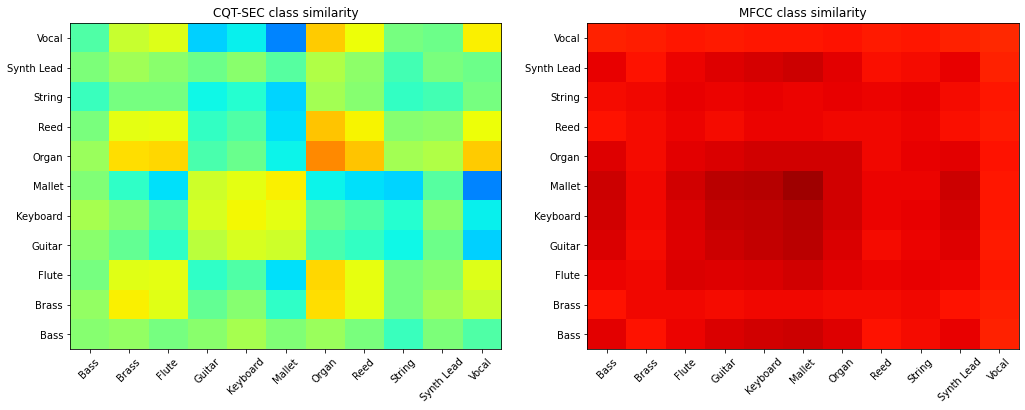

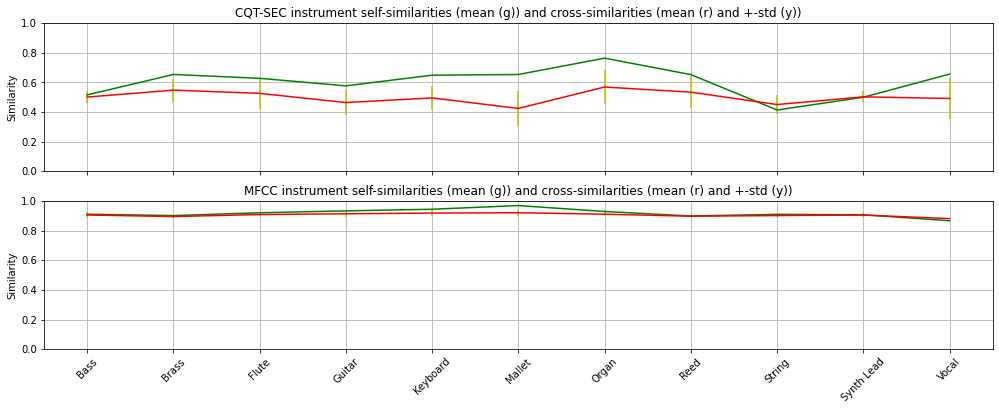

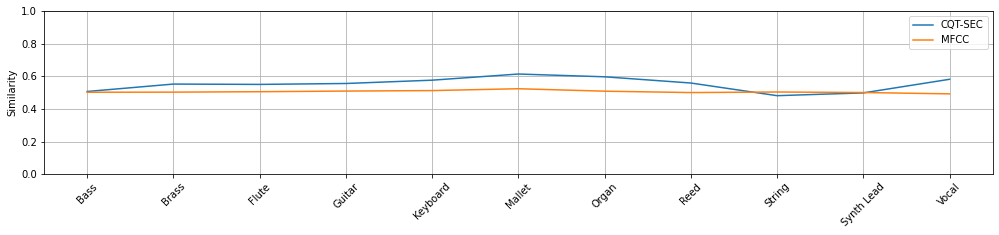

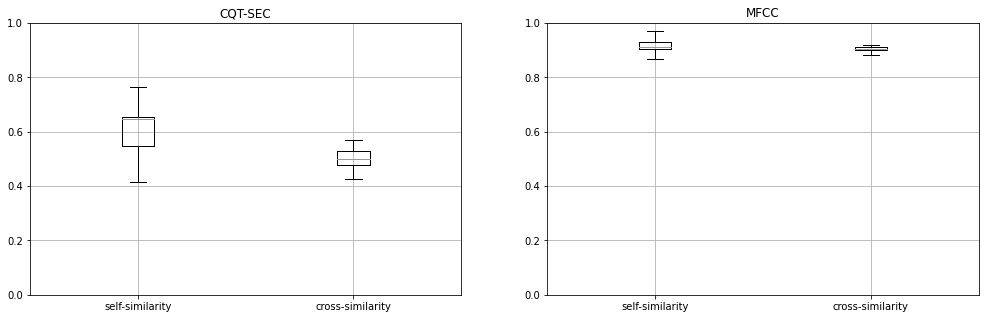

CQT-SEC score: 0.552484236869545
MFCC score: 0.5060553978861714


In [8]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the instrument similarity matrices
audio_dict = pickle.load(open('class_similarity.pkl', 'rb'))
cqtsec_similarity = audio_dict['cqt-sec']
mfcc_similarity = audio_dict['mfcc']

# Display the instrument similarity matrices
class_names = ['Bass', 'Brass', 'Flute', 'Guitar', 'Keyboard', 'Mallet', 'Organ', 'Reed', 'String', 'Synth Lead', 'Vocal']
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.imshow(cqtsec_similarity, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.xticks(np.arange(number_classes), class_names, rotation=45)
plt.yticks(np.arange(number_classes), class_names)
plt.title('CQT-SEC class similarity')
plt.subplot(1, 2, 2)
plt.imshow(mfcc_similarity, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.xticks(np.arange(number_classes), class_names, rotation=45)
plt.yticks(np.arange(number_classes), class_names)
plt.title('MFCC class similarity')
plt.show()


# Compute the self and cross-similarities for the CQT-SECs and the MFCCs
cqtsec_selfsimilarity = np.diag(cqtsec_similarity)
cqtsec_crosssimilarity = cqtsec_similarity[~np.eye(number_classes, dtype=bool)].reshape(number_classes,-1)
mfcc_selfsimilarity = np.diag(mfcc_similarity)
mfcc_crosssimilarity = mfcc_similarity[~np.eye(number_classes, dtype=bool)].reshape(number_classes,-1)

# Display the self-similarities and cross-similarities (with mean and +-std)
plt.figure(figsize=(17, 6))
plt.subplot(2, 1, 1)
plt.errorbar(np.arange(number_classes), np.mean(cqtsec_crosssimilarity, axis=1), \
             yerr=np.std(cqtsec_crosssimilarity, axis=1), ecolor='y', color='r')
plt.plot(cqtsec_selfsimilarity, color='g')
plt.ylim(0, 1)
plt.grid()
plt.title('CQT-SEC instrument self-similarities (mean (g)) and cross-similarities (mean (r) and +-std (y))')
plt.xticks(np.arange(number_classes), [])
plt.ylabel('Similarity')
plt.subplot(2, 1, 2)
plt.errorbar(np.arange(number_classes), np.mean(mfcc_crosssimilarity, axis=1), \
             yerr=np.std(mfcc_crosssimilarity, axis=1), ecolor='y', color='r')
plt.plot(mfcc_selfsimilarity, color='g')
plt.ylim(0, 1)
plt.grid()
plt.title('MFCC instrument self-similarities (mean (g)) and cross-similarities (mean (r) and +-std (y))')
plt.xticks(np.arange(number_classes), class_names, rotation=45)
plt.ylabel('Similarity')
plt.show()


# Compute the class similarity scores ((mean self-similarities + 1-mean cross-similarities)/2)
cqtsec_scores = (np.diag(cqtsec_similarity)\
                 +1-(np.sum(cqtsec_similarity, axis=0)-np.diag(cqtsec_similarity))/(number_classes-1))/2
mfcc_scores = (np.diag(mfcc_similarity)\
               +1-(np.sum(mfcc_similarity, axis=0)-np.diag(mfcc_similarity))/(number_classes-1))/2

# Display the instrument similarity scores
plt.figure(figsize=(17, 3))
plt.plot(cqtsec_scores, label='CQT-SEC')
plt.plot(mfcc_scores, label='MFCC')
plt.ylim(0, 1)
plt.grid()
plt.xticks(np.arange(number_classes), class_names, rotation=45)
plt.ylabel('Similarity')
plt.legend()
plt.show()


# Display the distributions for the instrument similarity scores
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.boxplot([cqtsec_selfsimilarity, np.mean(cqtsec_crosssimilarity, axis=1)])
plt.ylim(0, 1)
plt.xticks(np.arange(1, 2+1), ['self-similarity', 'cross-similarity'])
plt.grid()
plt.title('CQT-SEC')
plt.subplot(1, 2, 2)
plt.boxplot([mfcc_selfsimilarity, np.mean(mfcc_crosssimilarity, axis=1)])
plt.ylim(0, 1)
plt.xticks(np.arange(1, 2+1), ['self-similarity', 'cross-similarity'])
plt.grid()
plt.title('MFCC')
plt.show()

# Display the overall scores
print(f'CQT-SEC score: {np.mean(cqtsec_scores)}')
print(f'MFCC score: {np.mean(mfcc_scores)}')